In [2]:
import pandas as pd
import os
import glob
import matplotlib.ticker as ticker # type: ignore
from statannot import add_stat_annotation


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import numpy as np
import os
from matplotlib.ticker import MaxNLocator

from sklearn.metrics import roc_curve, auc

In [4]:
import os
import glob
import pandas as pd

#pkl_dir = '/data/users2/jwardell1/undersampling-project/HCP/pkl-files'
pkl_dir = '/data/users2/jwardell1/undersampling-project/OULU/pkl-files'

# Read and concatenate sr1 data
joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
joined_list = glob.glob(joined_files)
sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

# Read and concatenate sr2 data
joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
joined_list = glob.glob(joined_files)
sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

# Read and concatenate concat data
joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
joined_list = glob.glob(joined_files)
concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

# Read and concatenate add data
joined_files = os.path.join(pkl_dir, 'add_*.pkl')
joined_list = glob.glob(joined_files)
add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)

# Concatenate all dataframes
all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)



In [5]:
import pandas as pd

# Function to split each row into multiple rows based on cross-validation index
def split_row(row):
    new_rows = []
    for cv_ix, auc in enumerate(row['test_scores']):
        new_row = row.copy()
        new_row['auc'] = auc
        new_row['cv_ix'] = cv_ix
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)

# Apply the split_row function to each row of the dataframe and concatenate the results
result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)

# Drop the original 'test_scores' column as it's no longer needed
result_df.drop('test_scores', axis=1, inplace=True)


In [6]:
grouped_classifiers = result_df.groupby('classifier')


classifier_dfs = {}
for classifier, group_df in grouped_classifiers:
    classifier_dfs[classifier] = group_df.copy()

mlp_df = classifier_dfs['Multilayer Perceptron']
lr_df = classifier_dfs['Logistic Regression']
svm_df = classifier_dfs['SVM']
nb_df = classifier_dfs['Naive Bayes']

In [7]:
result_df.columns

Index(['graph_no', 'nstd', 'burnin', 'noise_no', 'snr', 'scalar', 'classifier',
       'target', 'predictions', 'test_proba', 'sampling_rate', 'auc', 'cv_ix'],
      dtype='object')

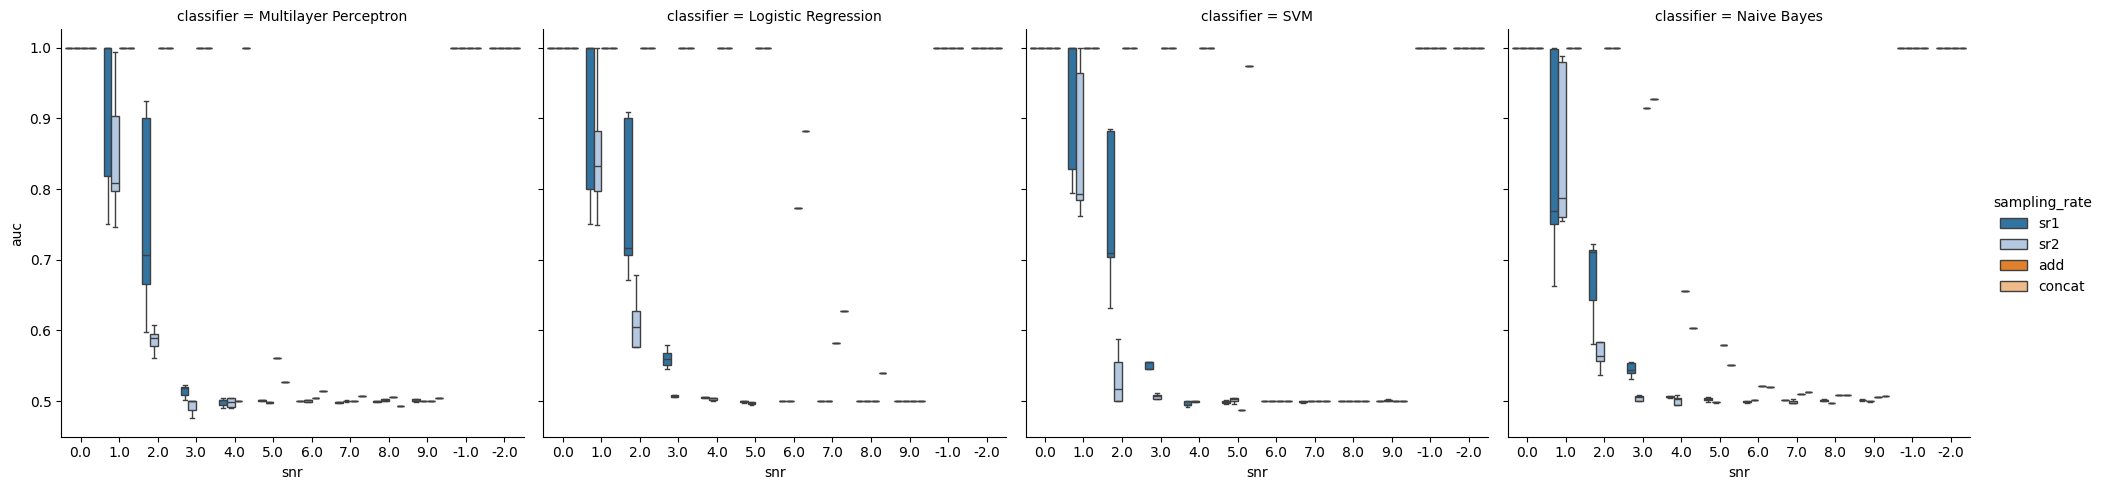

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt


dfs = [mlp_df, lr_df, svm_df, nb_df]

unique_snr_values = []
for df in dfs:
    unique_snr_values.extend(df['snr'].unique())
snr_levels = list(set(unique_snr_values))



classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
hue_order = sampling_rates
palette = { item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

# Combine all dataframes into one dataframe for plotting
combined_df = pd.concat(dfs)

# Plot all boxplots in one plot using catplot
ax = sns.catplot(
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    col="classifier",
    data=combined_df,
    kind="box",
    palette=palette,
    showfliers=False
)




#plt.savefig('all_-2_9.png')




p-value annotation legend:
°: 5.00e-02 < p <= 1.00e+00
*: p <= 5.00e-02



AttributeError: module 'seaborn.categorical' has no attribute '_BoxPlotter'

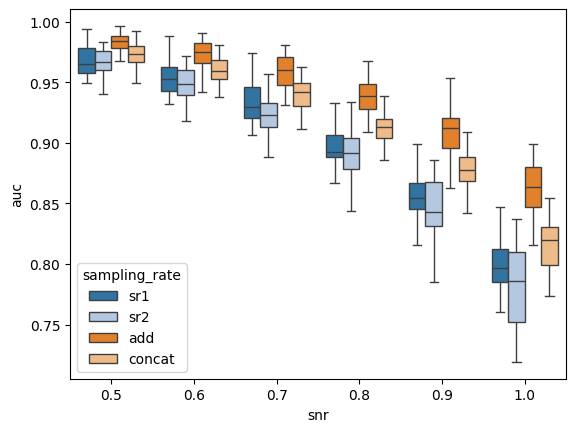

In [28]:
# Plot all boxplots in one plot using catplot
ax = sns.boxplot(
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    data=mlp_df,
    palette=palette,
    showfliers=False
)


from statannot import add_stat_annotation


#pairs = [((dataset, "Mean MLP"), (dataset, "DICE")) for dataset in ica_datasets]
pairs = [((snr_level, "0.5"), (snr_level, "1.0")) for snr_level in snr_levels]

add_stat_annotation(
    ax, 
    box_pairs=pairs,
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    data=combined_df,
    test='Wilcoxon',
    text_format='star',
    loc='inside', 
    verbose=1, 
    text_offset=-4,
    pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
)

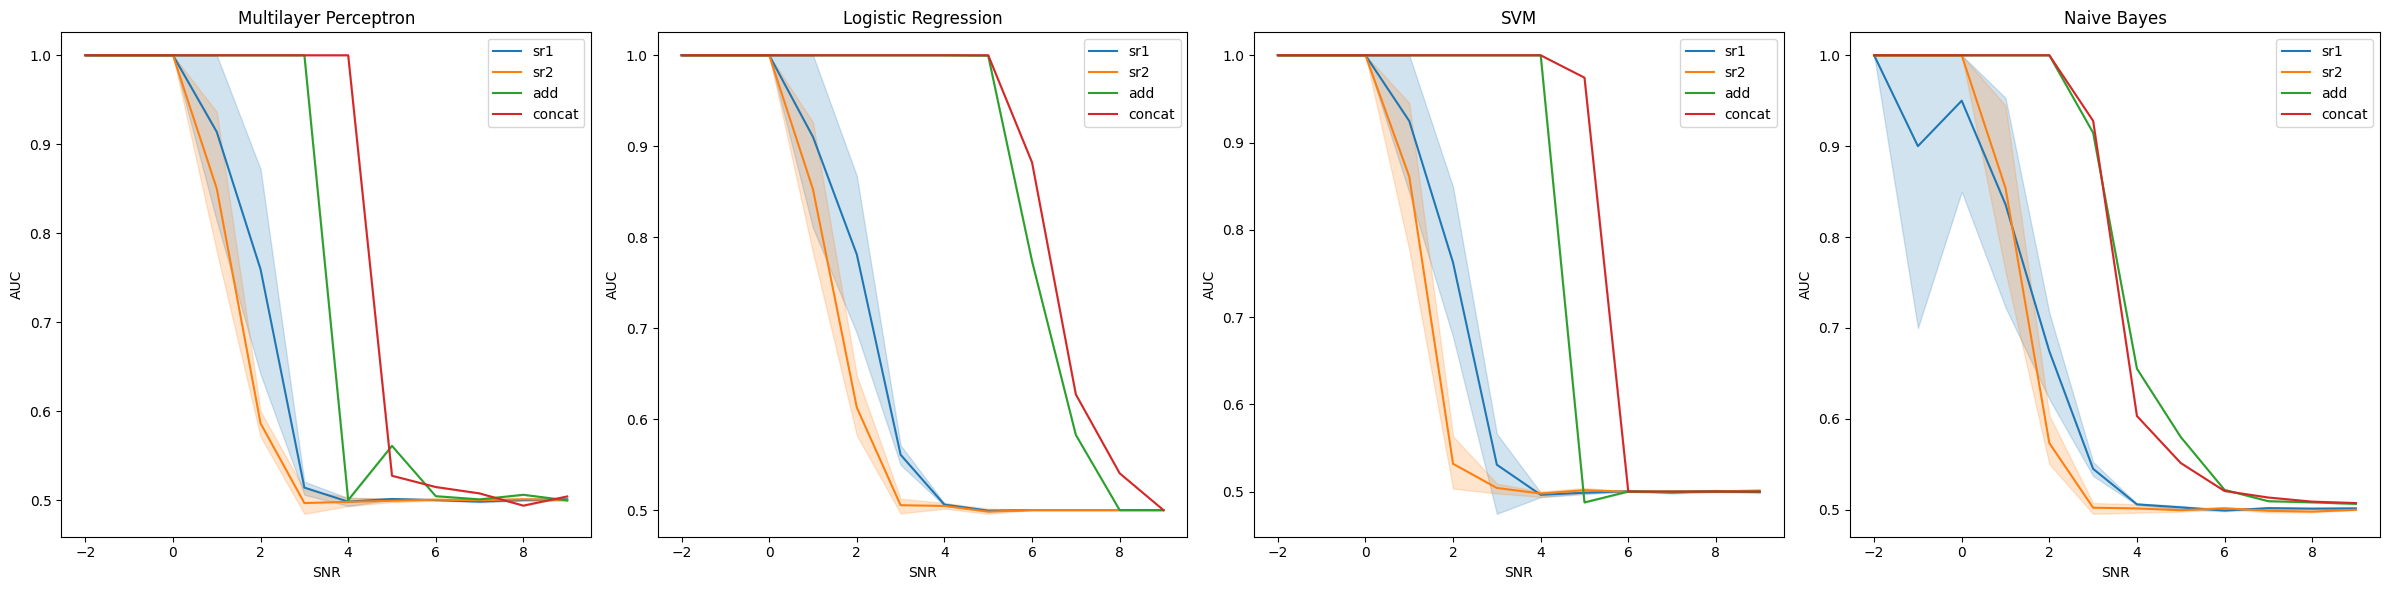

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plotting area
fig, axes = plt.subplots(ncols=len(classifiers), nrows=1, figsize=(6 * len(classifiers), 6))

# Iterate over each classifier
for i, classifier in enumerate(classifiers):
    # Filter DataFrame for the current classifier
    classifier_df = result_df[result_df['classifier'] == classifier]
    
    # Iterate over each sampling rate
    for sr in sampling_rates:
        # Filter DataFrame for the current sampling rate
        sr_df = classifier_df[classifier_df['sampling_rate'] == sr]
        
        # Plot the line for the current sampling rate
        sns.lineplot(x='snr', y='auc', data=sr_df, ax=axes[i], label=sr)

    # Set plot title and labels
    axes[i].set_title(classifier)
    axes[i].set_xlabel('SNR')
    axes[i].set_ylabel('AUC')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
dfs = [mlp_df, lr_df, svm_df, nb_df]
combined_df = pd.concat(dfs)


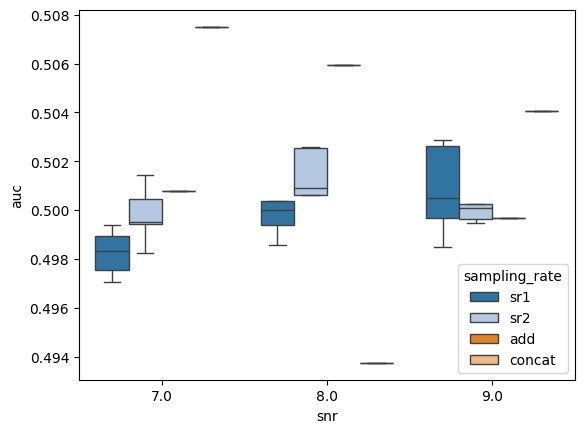

In [23]:
classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
hue_order = sampling_rates
palette = { item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}
snr_levels = [7.0, 8.0, 9.0]


ax = sns.boxplot(
    x="snr", 
    y="auc",
    order=snr_levels,
    hue="sampling_rate",
    hue_order=hue_order,
    data=mlp_df,
    palette=palette,
    showfliers=False
)

In [18]:
snr_levels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, -1.0, -2.0]